In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import tempfile
import os

In [2]:
def plot_loss_graph(train_loss, dev_loss, use_log=True):
    if use_log:
        train_loss = np.log(train_loss)
        dev_loss = np.log(dev_loss)
    plt.figure(figsize=(10, 6))
    train_line, = plt.plot(train_loss, label='train')
    dev_line, = plt.plot(dev_loss, label='dev')
    plt.legend(handles=[train_line, dev_line])
    plt.show()

## 1. Define VGG-16 Architecture

In [3]:
class VGG16:
    def __init__(self, img_size, num_categories, learning_rate, momentum=0.9, filter_size=(3, 3)):
        self._tf_graph = tf.Graph()
        self._saved_model_path = os.path.join(tempfile.mkdtemp(), 'model.ckpt')
        self._tf_dict = self._get_tf_dict(self._tf_graph, img_size, num_categories, learning_rate, momentum)
        self._train_loss = []
        self._dev_loss = []

    def train(self, dataset, batch_size, num_epoch, loss_interval=10):
        print('Started training...')
        
        self._train_loss = []
        self._dev_loss = []
        
        start = time.time()
        sample_count = 0
        with self._tf_graph.as_default():
            with tf.Session(graph=self._tf_graph) as sess:
                sess.run(tf.global_variables_initializer())
                last_epoch = 0
                while last_epoch < num_epoch:
                    batch = dataset.train.next_batch(batch_size)
                    feed_dict = {
                        self._tf_dict['X']: batch[0],
                        self._tf_dict['Y']: batch[1]
                    }
                    sess.run(self._tf_dict['optimizer'], feed_dict=feed_dict)
                    sample_count += batch[0].shape[0]
                    epoch = sample_count // batch_size
                    if epoch > last_epoch:
                        last_epoch = epoch
                        if epoch % loss_interval == 0:
                            self._train_loss.append(sess.run(self._tf_dict['cost'], feed_dict={
                                self._tf_dict['X']: batch[0],
                                self._tf_dict['Y']: batch[1]
                            }))
                            self._dev_loss.append(sess.run(self._tf_dict['cost'], feed_dict={
                                self._tf_dict['X']: dataset.test.images,
                                self._tf_dict['Y']: dataset.test.labels
                            }))
                    if (epoch + 1) % 100 == 0:
                        print('Finished epoch {0}...'.format(epoch + 1))
                saver = tf.train.Saver()
                saver.save(sess, self._saved_model_path)
                print('Finished training, modeld saved.')

                end = time.time()
                print('Time elapsed: {0:.2f}s.'.format(end - start))

    def predict(self, data):
        with self._tf_graph.as_default():
            with tf.Session(graph=self._tf_graph) as sess:
                saver = tf.train.Saver()
                saver.restore(sess, self._saved_model_path)
                return sess.run(self._tf_dict['prediction'], feed_dict={self._tf_dict['X']: data})

    @classmethod
    def _get_tf_dict(cls, grah, img_size, num_categories, learning_rate, momentum):
        with grah.as_default():
            res = dict()
            res['X'] = tf.placeholder(tf.float32, shape=(None, *img_size), name='input')
            res['Y'] = tf.placeholder(tf.float32, shape=(None, num_categories), name='output')

            res['filter_1'], res['conv_1'] = cls._filter_conv(res['X'], shape=(3, 3, img_size[-1], 64))
            res['filter_2'], res['conv_2'] = cls._filter_conv(res['conv_1'], shape=(3, 3, 64, 64))
            res['maxpool_3'] = cls._pool(res['conv_2'], 'MAX')

            res['filter_4'], res['conv_4'] = cls._filter_conv(res['maxpool_3'], shape=(3, 3, 64, 128))
            res['filter_5'], res['conv_5'] = cls._filter_conv(res['conv_4'], shape=(3, 3, 128, 128))
            res['maxpool_6'] = cls._pool(res['conv_5'], 'MAX')

            res['filter_7'], res['conv_7'] = cls._filter_conv(res['maxpool_6'], shape=(3, 3, 128, 256))
            res['filter_8'], res['conv_8'] = cls._filter_conv(res['conv_7'], shape=(3, 3, 256, 256))
            res['filter_9'], res['conv_9'] = cls._filter_conv(res['conv_8'], shape=(3, 3, 256, 256))
            res['maxpool_10'] = cls._pool(res['conv_9'], 'MAX')

#             res['filter_11'], res['conv_11'] = cls._filter_conv(res['maxpool_10'], shape=(3, 3, 256, 512))
#             res['filter_12'], res['conv_12'] = cls._filter_conv(res['conv_11'], shape=(3, 3, 512, 512))
#             res['filter_13'], res['conv_13'] = cls._filter_conv(res['conv_12'], shape=(3, 3, 512, 512))
#             res['maxpool_14'] = cls._pool(res['conv_13'], 'MAX')

#             res['filter_15'], res['conv_15'] = cls._filter_conv(res['maxpool_14'], shape=(3, 3, 512, 512))
#             res['filter_16'], res['conv_16'] = cls._filter_conv(res['conv_15'], shape=(3, 3, 512, 512))
#             res['filter_17'], res['conv_17'] = cls._filter_conv(res['conv_16'], shape=(3, 3, 512, 512))
#             res['maxpool_18'] = cls._pool(res['conv_17'], 'MAX')

#             unfold_shape = [512] if img_size[-1] == 1 else [7 * 7 * 512] # TODO: a hack
            res['fc_19'] = tf.layers.Flatten()(res['maxpool_10'])
            res['fc_20'] = tf.layers.dense(inputs=res['fc_19'], units=2048, activation=tf.nn.relu, trainable=True)
            res['fc_21'] = tf.layers.dense(inputs=res['fc_20'], units=2048, activation=tf.nn.relu, trainable=True)
            res['fc_22'] = tf.layers.dense(inputs=res['fc_21'], units=num_categories, activation=None, trainable=True)

            res['cost'] = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits_v2(
                labels=res['Y'],
                logits=res['fc_22']
            ))
            res['prediction'] = tf.argmax(tf.nn.softmax(res['fc_22'], axis=-1), axis=-1)
            res['optimizer'] = tf.train.AdamOptimizer(
                learning_rate=learning_rate,
                beta1=momentum
            ).minimize(res['cost'])

            return res

    @classmethod
    def _filter_conv(cls, input_value, shape, strides=(1, 1, 1, 1), padding='SAME', dtype=tf.float32):
        res_filter = tf.Variable(tf.random_normal(shape), dtype=tf.float32, trainable=True)
        res_conv = tf.nn.conv2d(input=input_value, filter=res_filter, strides=strides, padding=padding)
        res_relu = tf.nn.relu(res_conv)
        return res_filter, res_relu
    
    @classmethod
    def _pool(cls, input_value, pool_style, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1), padding='SAME'):
        res_func = tf.nn.max_pool if pool_style == 'MAX' else tf.nn.avg_pool
        return res_func(value=input_value, ksize=ksize, strides=strides, padding=padding)

## 2. Get MNIST Dataset

In [4]:
from tensorflow.examples.tutorials.mnist import input_data

In [6]:
mnist = input_data.read_data_sets("data/mnist", one_hot=True, reshape=False)

Extracting data/mnist\train-images-idx3-ubyte.gz
Extracting data/mnist\train-labels-idx1-ubyte.gz
Extracting data/mnist\t10k-images-idx3-ubyte.gz
Extracting data/mnist\t10k-labels-idx1-ubyte.gz


In [7]:
model = VGG16(
    img_size=mnist.train.images.shape[1:],
    num_categories=mnist.train.labels.shape[-1],
    learning_rate=1e-3
)

In [8]:
model.train(mnist, batch_size=512, num_epoch=5000)

Started training...
Finished epoch 100...
Finished epoch 200...
Finished epoch 300...
Finished epoch 400...
Finished epoch 500...
Finished epoch 600...
Finished epoch 700...
Finished epoch 800...
Finished epoch 900...
Finished epoch 1000...
Finished epoch 1100...
Finished epoch 1200...
Finished epoch 1300...
Finished epoch 1400...
Finished epoch 1500...
Finished epoch 1600...
Finished epoch 1700...
Finished epoch 1800...
Finished epoch 1900...
Finished epoch 2000...
Finished epoch 2100...
Finished epoch 2200...
Finished epoch 2300...
Finished epoch 2400...
Finished epoch 2500...
Finished epoch 2600...
Finished epoch 2700...
Finished epoch 2800...
Finished epoch 2900...
Finished epoch 3000...
Finished epoch 3100...
Finished epoch 3200...
Finished epoch 3300...
Finished epoch 3400...
Finished epoch 3500...
Finished epoch 3600...
Finished epoch 3700...
Finished epoch 3800...
Finished epoch 3900...
Finished epoch 4000...
Finished epoch 4100...
Finished epoch 4200...
Finished epoch 4300...


c:\program files\python35\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


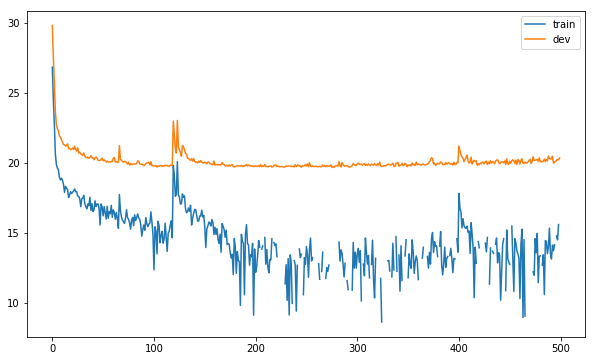

In [9]:
plot_loss_graph(model._train_loss, model._dev_loss)

In [10]:
model.predict(mnist.test.images[:20])

INFO:tensorflow:Restoring parameters from C:\Users\SHUYAN~1\AppData\Local\Temp\tmpol8i075c\model.ckpt


array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4],
      dtype=int64)

In [11]:
np.argmax(mnist.test.labels[:20], axis=-1)

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4],
      dtype=int64)

In [12]:
accuracy = np.count_nonzero(model.predict(mnist.test.images).ravel() == np.argmax(mnist.test.labels, axis=-1).ravel()) / mnist.test.labels.shape[0]

INFO:tensorflow:Restoring parameters from C:\Users\SHUYAN~1\AppData\Local\Temp\tmpol8i075c\model.ckpt


In [13]:
accuracy

0.9713